Populating the interactive namespace from numpy and matplotlib


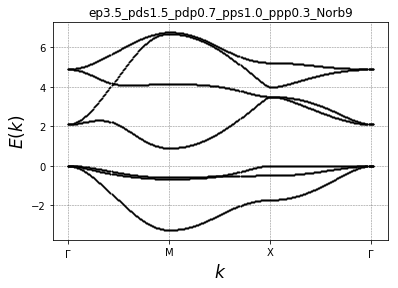

In [9]:
%pylab inline

import math
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg
import sys
import matplotlib.pyplot as plt
sys.path.append('../../src/')

from pylab import *
from hamiltonian import Parameters

M_PI = math.pi
ed = 0
ep = 3.5

# IMPORTANT: keep all hoppings below positive to avoid confusion
#            hopping signs are considered in dispersion separately
tpd = 1.3
tpp = 0.6
pds = 1.5
pdp = 0.7
pps = 1.0
ppp = 0.3
Norb = 9

if Norb==3:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_Norb'+str(Norb)
elif Norb==7:
    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_Norb'+str(Norb)
elif Norb==9:
    fname = 'ep'+str(ep)+'_pds'+str(pds)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_Norb'+str(Norb)

def generateM(sa,sb,ca,cb):
    M = zeros((Norb,Norb))
    if Norb==3:
        # d_x2-y2 and px,py
        M = [[ed,          -2*tpd*sa*1j,       2*tpd*sb*1j],\
            [2*tpd*sa*1j,    ep,               4*tpp*sa*sb], \
            [-2*tpd*sb*1j,  4*tpp*sa*sb,       ep]] 
    elif Norb==7:
        # orbital order: dx2-y2, d3z2-r2, px, py (effectively 4-orbitals)
        # Note that there are no dxy, dxz and dyz because they do not couple to others
        # But remember that they form 3 flat bands in the finite band structure
        M = [[ed,                  0,               -2*tpd*sa*1j,           2*tpd*sb*1j],\
             [0,                  ed,               -2*tpd/sqrt(3)*sa*1j,  -2*tpd/sqrt(3)*sb*1j],\
             [2*tpd*sa*1j,  2*tpd/sqrt(3)*sa*1j,      ep,                   4*tpp*sa*sb], \
             [-2*tpd*sb*1j, 2*tpd/sqrt(3)*sb*1j,     4*tpp*sa*sb,            ep]] 
    elif Norb==9:
        # orbital order: px1, px2, py1, py2, dx2-y2, d3z2-r2, dxy (effectively 7-orbitals)
        # Note that there are no dxz and dyz because they do not couple to others
        # But remember that they form 2 flat bands in the finite band structure
        tpd_x2y2  = pds/2.0*sqrt(3)
        tpd_3z2r2 = pds/2.0
        tpd_xy = pdp
        
        ex1 = 2.*tpd_x2y2 *sa*1j
        ex2 = 2.*tpd_3z2r2*sa*1j
        ex3 = 2.*tpd_xy   *sa*1j
        ey1 = 2.*tpd_x2y2 *sb*1j
        ey2 = 2.*tpd_3z2r2*sb*1j
        ey3 = 2.*tpd_xy   *sb*1j
        
        e1 = 2.*(ppp-pps)*ca*cb
        e2 = 2.*(ppp+pps)*sa*sb
        
        # Mona's matrix using her convention (signs) of py2 and dxy 
        M = [[ep,      e1,      0,      -e2,         ex1,      -ex2,        0],\
             [e1,      ep,    -e2,        0,           0,         0,     -ey3],\
             [0,      -e2,     ep,       e1,           0,         0,      ex3], \
             [-e2,      0,     e1,       ep,         ey1,       ey2,        0], \
             [-ex1,     0,      0,     -ey1,          ed,         0,        0], \
             [ex2,      0,      0,     -ey2,           0,         ed,       0], \
             [0,      ey3,    -ex3,       0,           0,         0,       ed]] 
        
        # Mi's matrix using sign convention: py2 up+ dn- and d_3z2-r2 positive sign
        # Note: if you change the sign for an orbital, then you also have to put an extra minus 
        # in any matrix element that involves that orbital with another (unchanged one);
        # whereas diagonal matrix elements stay unchanged. This is because
        # <a|H|-b> = - <a|H|b> while <-b|H|-b> = <b|H|b>
        # If you change the sign of two orbitals, then matrix element is unchanged <-a|H|-b> = <a|H|b>
        M = [[ep,      e1,      0,       e2,          ex1,       ex2,        0],\
             [e1,      ep,     e2,        0,            0,         0,     -ey3],\
             [0,       e2,     ep,       e1,            0,         0,     -ex3], \
             [e2,       0,     e1,       ep,         -ey1,       ey2,        0], \
             [-ex1,     0,      0,       ey1,          ed,         0,        0], \
             [-ex2,     0,      0,      -ey2,           0,        ed,        0], \
             [0,      ey3,    ex3,        0,            0,         0,       ed]] 
    return M

Ms = ['-b','-r','-g','-m','-k','-c','-y']
cnt = 0
Npts = 100.
# from (0,0) to (pi,pi)
for kx in np.arange(0.,M_PI,M_PI/Npts):
    ky = kx
    skx = sin(kx/2.0)
    sky = sin(ky/2.0)
    if Norb==9:
        ckx = cos(kx/2.0)
        cky = cos(ky/2.0)
    else:
        # no c and d so just choose random numbers
        ckx = 0
        cky = 0
    M = generateM(skx,sky,ckx,cky)
    Ek, V = eigh(M)
    #print kx,ky
    #print Ek
    for i in range(0,len(Ek)):
        plt.plot(cnt,Ek[i],'ko',markersize=1)
    cnt += 1

# from (pi,pi) to (pi,0)
for ky in np.arange(M_PI,0.,-M_PI/Npts):
    kx = M_PI
    skx = sin(kx/2.0)
    sky = sin(ky/2.0)
    if Norb==9:
        ckx = cos(kx/2.0)
        cky = cos(ky/2.0)
    else:
        # no c and d so just choose random numbers
        ckx = 0
        cky = 0
    M = generateM(skx,sky,ckx,cky)
    Ek, V = eigh(M)
    for i in range(0,len(Ek)):
        plt.plot(cnt,Ek[i],'ko',markersize=1)
    cnt += 1

# from (pi,0) to (0,0)
for kx in np.arange(M_PI,0.,-M_PI/Npts):
    ky = 0.0
    skx = sin(kx/2.0)
    sky = sin(ky/2.0)
    if Norb==9:
        ckx = cos(kx/2.0)
        cky = cos(ky/2.0)
    else:
        # no c and d so just choose random numbers
        ckx = 0
        cky = 0
    M = generateM(skx,sky,ckx,cky)
    Ek, V = eigh(M)
    for i in range(0,len(Ek)):
        plt.plot(cnt,Ek[i],'ko',markersize=1)
    cnt += 1

xlabel('$k$',fontsize=17)
ylabel('$E(k)$',fontsize=17)
xticks((0,Npts,2.*Npts,3.*Npts), (r'$\Gamma$','M','X',r'$\Gamma$'))
#text(0.45, 0.1, '(a)', fontsize=16)
title(fname)
grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
legend(loc='best', fontsize=9.5, framealpha=1.0, edgecolor='black')
savefig("Ek_"+fname+".pdf")